In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from scipy.io import wavfile
import os
from tqdm import tqdm
import torchaudio
import torch
from scipy.io import wavfile

In [2]:
wsj0path = "/project/data_asr/wham_dataset/whamr_data/wsj0_raw/"

cv = []
with open('mix_2_spk_cv.txt','r') as txt:
    out = txt.readline()
    while out != "":
        out = out.split()
        cv.append([out[0],out[2]])
        out = txt.readline()

tr = []
with open('mix_2_spk_tr.txt','r') as txt:
    out = txt.readline()
    while out != "":
        out = out.split()
        tr.append([out[0],out[2]])
        out = txt.readline()

tt = []
with open('mix_2_spk_tt.txt','r') as txt:
    out = txt.readline()
    while out != "":
        out = out.split()
        tt.append([out[0],out[2]])
        out = txt.readline()

print("tr:",len(tr))
print("cv:",len(cv))
print("tt:",len(tt))
print(tr[0])

tr: 20000
cv: 5000
tt: 3000
['wsj0/si_tr_s/40n/40na010x.wav', 'wsj0/si_tr_s/01x/01xo031a.wav']


In [3]:
tr[0][0].split("/")[-1][:-4]

'40na010x'

In [4]:
def same_length(a:torch.Tensor,b:torch.Tensor):
    len_a = a.shape[1]
    len_b = b.shape[1]
    if len_a > len_b:
        add = len_a - len_b
        b = torch.cat([b,torch.zeros(add).unsqueeze(0)],dim=1)
    elif len_b > len_a:
        add = len_b - len_a
        a = torch.cat([a,torch.zeros(add).unsqueeze(0)],dim=1)
    return a, b

/project/data_asr/wham_dataset/whamr_data/wsj0_raw/wsj0/si_tr_s/01t/01to030v.wav
155419
61760
/project/data_asr/wham_dataset/whamr_data/wsj0_raw/wsj0/si_tr_s/40n/40na010x.wav
105827
185099
/project/data_asr/wham_dataset/whamr_data/wsj0_raw/wsj0/si_et_05/445/445c0206.wav
66602
85440


'Done'

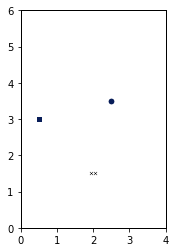

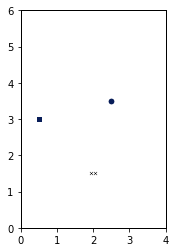

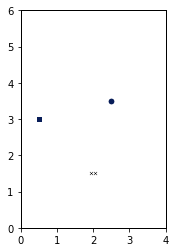

In [26]:
CREATE_PATH = "/project/data_asr/CHiME5/data/wsj0-mix2/twoChannelRoom/"

def create_dataset(part: list, subfolder: str):
    scenarios = ["mix/","s1/","s2/"]
    for scenario in scenarios:
        print("Generate",scenario,"for",subfolder)
        for line in tqdm(part):
            # Load two audiofiles
            
            fs, wav_a = wavfile.read(wsj0path+line[0])
            fs, wav_b = wavfile.read(wsj0path+line[1])
            #wav_a, wav_b = same_length(wav_a,wav_b)

            # Simulate room and obtain mix / s1 / s2
            room = pra.ShoeBox([4,6], fs=fs)

            if scenario == "mix/":
                room.add_source([2.5, 3.5], signal=wav_a, delay=0)
                room.add_source([0.5, 3.0], signal=wav_b, delay=0)
                R = pra.linear_2D_array([2, 1.5], 2, 0, 0.1)
                room.add_microphone_array(pra.Beamformer(R, room.fs))
            elif scenario == "s1/":
                room.add_source([2.5, 3.5], signal=wav_a, delay=0)
                R = pra.linear_2D_array([2, 1.5], 1, 0, 0.1)
                room.add_microphone_array(pra.Beamformer(R, room.fs))
            elif scenario == "s2/":
                room.add_source([0.5, 3.0], signal=wav_b, delay=0)
                R = pra.linear_2D_array([2, 1.5], 1, 0, 0.1)
                room.add_microphone_array(pra.Beamformer(R, room.fs))
            
            room.simulate()

            name_file = line[0].split("/")[-1][:-4] + "_" + line[1].split("/")[-1]
            room.mic_array.to_wav(
                (CREATE_PATH + subfolder + scenario + name_file),
                norm=True,
                bitdepth=np.int16,
            )
    return "Done"

create_dataset(cv,"cv/")
create_dataset(tr,"tr/")
create_dataset(tt,"tt/")